In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [ ]:
# df = pd.read_csv('https://raw.githubusercontent.com/Frazanhibriz/Product_Review_Analysis/refs/heads/main/tokopedia_review.csv')
# df.head()

In [ ]:
# def get_sentiment(rating):
#     if rating <= 2:
#         return 'negative'
#     elif rating == 3:
#         return 'neutral'
#     else:
#         return 'positive'

# df['sentiment'] = df['rating'].apply(get_sentiment)
# df = df[['text', 'sentiment']].dropna()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df['text'], df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42
# )

In [ ]:
# tfidf = TfidfVectorizer(max_features=5000)
# X_train_tfidf = tfidf.fit_transform(X_train)
# X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [ ]:
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train_resampled, y_train_resampled)

In [ ]:
# y_pred = model.predict(X_test_tfidf)

# print("Classification Report:\n")
# print(classification_report(y_test, y_pred))

In [ ]:
# conf_matrix = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['positive', 'neutral', 'negative'],
#             yticklabels=['positive', 'neutral', 'negative'])
# plt.title("Confusion Matrix After SMOTE")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# classes = ['positive', 'neutral', 'negative']
# weights = compute_class_weight(class_weight='balanced', classes=np.array(classes), y=y_train)
# class_weight_dict = {cls: w for cls, w in zip(classes, weights)}
# print("Class Weights:", class_weight_dict)

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# y_train_enc = le.fit_transform(y_train)
# y_test_enc = le.transform(y_test)

In [ ]:
# sample_weights = np.array([class_weight_dict[label] for label in y_train])

# model = XGBClassifier(
#     objective='multi:softmax',
#     num_class=3,
#     eval_metric='mlogloss',
#     use_label_encoder=False,
#     random_state=42
# )

# model.fit(X_train_tfidf, y_train_enc, sample_weight=sample_weights)

In [ ]:
# y_pred_enc = model.predict(X_test_tfidf)
# y_pred = le.inverse_transform(y_pred_enc)
# y_true = le.inverse_transform(y_test_enc)

# print("Classification Report:\n")
# print(classification_report(y_true, y_pred))

In [ ]:
# conf_matrix = confusion_matrix(y_true, y_pred, labels=classes)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=classes, yticklabels=classes)
# plt.title("Confusion Matrix XGBoost")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

## Versi 1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
!pip install -q transformers datasets evaluate scikit-learn
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Frazanhibriz/Product_Review_Analysis/refs/heads/main/tokopedia_review_cleaned.csv")
df = df[['cleaned_text', 'sentiment']].dropna()
df.head()

,cleaned_text,sentiment
0,barang sesuai pesan cepat,positive
1,barang bagus harga murah,positive
2,paket rapimantapcepatsampe tuju,positive
3,ya puas dgn barang,positive
4,responya b mantap,positive


In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(example):
    return tokenizer(example["cleaned_text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/32308 [00:00<?, ? examples/s]

Map:   0%|          | 0/8078 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ✅ 11. Training model
trainer.train()

/tmp/ipython-input-23-3535765374.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: frazanhibriz2004 (frazanhibriz2004-telkom-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.293000,0.282079,0.932780,0.908169
2,0.223800,0.279768,0.933399,0.908257
3,0.213800,0.286194,0.933647,0.907721


TrainOutput(global_step=6060, training_loss=0.26741602672602083, metrics={'train_runtime': 5215.5986, 'train_samples_per_second': 18.583, 'train_steps_per_second': 1.162, 'total_flos': 6375501224967168.0, 'train_loss': 0.26741602672602083, 'epoch': 3.0})

In [ ]:
metrics = trainer.evaluate()

print(f"Akurasi: {metrics['eval_accuracy']:.4f}")
print(f"F1-score: {metrics['eval_f1']:.4f}")


Akurasi: 0.9336
F1-score: 0.9077


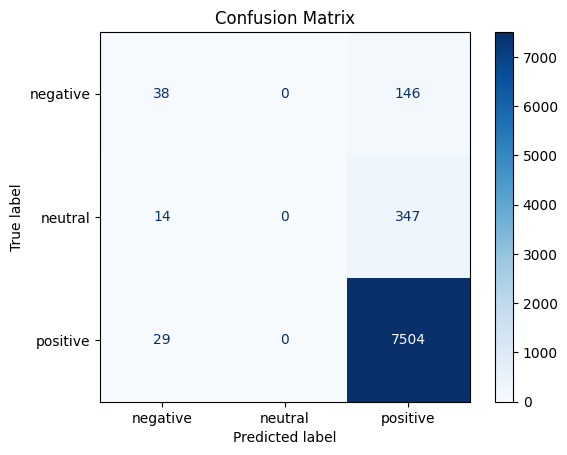

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

labels = label_encoder.classes_

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model_path = "./sentiment_model"

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

import pickle
with open(f"{model_path}/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

labels = label_encoder.classes_
report = classification_report(y_true, y_pred, target_names=labels)
print(report)


              precision    recall  f1-score   support

    negative       0.47      0.21      0.29       184
     neutral       0.00      0.00      0.00       361
    positive       0.94      1.00      0.97      7533

    accuracy                           0.93      8078
   macro avg       0.47      0.40      0.42      8078
weighted avg       0.89      0.93      0.91      8078



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Versi 2

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Frazanhibriz/Product_Review_Analysis/refs/heads/main/tokopedia_review.csv')
df = df[['text', 'rating']].copy()

def convert_rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentimen'] = df['rating'].apply(convert_rating_to_sentiment)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text'] = df['text'].apply(clean_text)
df.dropna(subset=['text', 'sentimen'], inplace=True)

In [ ]:
df_pos = df[df.sentimen == 'positive']
df_neu = df[df.sentimen == 'neutral']
df_neg = df[df.sentimen == 'negative']

df_neu_over = resample(df_neu, replace=True, n_samples=len(df_pos), random_state=42)
df_neg_over = resample(df_neg, replace=True, n_samples=len(df_pos), random_state=42)

df_balanced = pd.concat([df_pos, df_neu_over, df_neg_over]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
label_encoder = LabelEncoder()
df_balanced['label'] = label_encoder.fit_transform(df_balanced['sentimen'])

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
texts = df_balanced['text'].tolist()
labels = df_balanced['label'].tolist()

X_train, X_eval, y_train, y_eval = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = ReviewDataset(X_train, y_train, tokenizer)
eval_dataset = ReviewDataset(X_eval, y_eval, tokenizer)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=3)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro"),
    }

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: frazanhibriz2004 (frazanhibriz2004-telkom-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
preds_output = trainer.predict(eval_dataset)
y_pred = torch.argmax(torch.tensor(preds_output.predictions), axis=1)
y_true = preds_output.label_ids

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

In [ ]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Frazanhibriz/Product_Review_Analysis/refs/heads/main/tokopedia_review.csv')
df_raw = df_raw[['text', 'rating']].copy()

df_raw['sentimen'] = df_raw['rating'].apply(convert_rating_to_sentiment)
df_raw['text'] = df_raw['text'].apply(clean_text)
df_raw.dropna(subset=['text', 'sentimen'], inplace=True)

df_test_external = df_raw.sample(n=100, random_state=123)

df_test_external['label'] = label_encoder.transform(df_test_external['sentimen'])


In [ ]:
external_dataset = ReviewDataset(
    df_test_external['text'].tolist(),
    df_test_external['label'].tolist(),
    tokenizer
)

In [ ]:
preds_external = trainer.predict(external_dataset)
y_pred_external = torch.argmax(torch.tensor(preds_external.predictions), axis=1)
y_true_external = preds_external.label_ids

print("Classification Report on External Data:\n")
print(classification_report(y_true_external, y_pred_external, target_names=label_encoder.classes_))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_true_external, y_pred_external)

labels = label_encoder.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on External Data")
plt.tight_layout()
plt.show()

In [ ]:
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")